In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('omw-1.4')
from nltk import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from collections import Counter

import emoji
from emot.emo_unicode import UNICODE_EMOJI,EMOTICONS_EMO,EMOJI_UNICODE

In [2]:
tweets = pd.read_csv("../data/cyberbullying_tweets.csv")

In [3]:
tweets.shape

(47692, 2)

In [4]:
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

<AxesSubplot:ylabel='cyberbullying_type'>

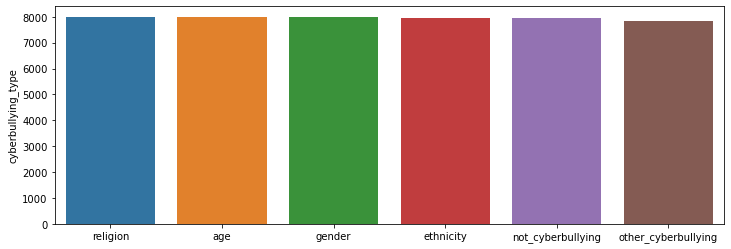

In [6]:
plt.figure(figsize=(12,4))
sns.barplot(x=tweets['cyberbullying_type'].value_counts().index, y=tweets['cyberbullying_type'].value_counts())

## Data preprocessing

### Extract hashtags, mentions, links and emojis

In [7]:
def extract_hashtags(self):
    regex = "#(\w+)"
    hashtag_list = re.findall(regex, self)
    l=[]
    for x in hashtag_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(hashtag_list) > 0:
        return ' '.join(hashtag_list)
    else:
        return ''

def extract_tags(self):
    regex = "@(\w+)"
    name_tag = re.findall(regex, self)
    l=[]
    for x in name_tag:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(l) > 0:
        return ' '.join(l)
    else:
        return ''
#     return l if l else ''

def extract_links(self):
    regex = r'(https?://\S+)'
    url_list = re.findall(regex, self)
    l=[]
    for x in url_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(url_list) > 0:
        return ' '.join(url_list)
    else:
        return ''
#     return url_list if url_list else ''

def extract_emojis(self):
    emoji_list = ''.join(c for c in self if c in emoji.UNICODE_EMOJI['en'])
    text_emoji =  ''.join(emoji.demojize(x) for x in emoji_list if x)
    regex = r"\:(.*?)\:"
    text_emoji =  re.findall(regex, text_emoji)
    if len(text_emoji) > 0:
        return ' '.join(text_emoji)
    else:
        return ''
#     return text_emoji if text_emoji else ''

In [8]:
tweets['tweet_text'] = tweets['tweet_text'].str.lower()
tweets['hash_tag']   = tweets['tweet_text'].apply(extract_hashtags)
tweets['name_tag']   = tweets['tweet_text'].apply(extract_tags)
tweets['url_tag']    = tweets['tweet_text'].apply(extract_links)
tweets['emoji_tag']  = tweets['tweet_text'].apply(extract_emojis)

In [9]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,"in other words #katandandre, your food was cra...",not_cyberbullying,katandandre mkr,,,
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,,xochitlsuckkks,,
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,,jasongio,,
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,,rudhoeenglish,,


### Remove the symbols and numbers from tweet text

In [10]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub(r"[^a-zA-Z ]+", '', x))

In [11]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,in other words katandandre your food was crapi...,not_cyberbullying,katandandre mkr,,,
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,xochitlsuckkks a classy whore or more red velv...,not_cyberbullying,,xochitlsuckkks,,
3,jasongio meh p thanks for the heads up but no...,not_cyberbullying,,jasongio,,
4,rudhoeenglish this is an isis account pretendi...,not_cyberbullying,,rudhoeenglish,,


### Remove the hashtags, mentions, url and emojis from tweet text

In [12]:
def clean_text(text,dirt):
    dirt = dirt.split()
    for x in dirt:
        text = text.replace(x,'')
        text = " ".join(text.split())
    return text

In [13]:
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['name_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['hash_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['url_tag']),axis=1)

In [14]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,,,
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,,
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,,
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,,


### Process the tweets

In [15]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('à', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [16]:
STOPWORDS = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [17]:
def clean_tweet(text):
    # Remove Hashtag, Mention, https, www.asdfd, dsfadsf.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', str(text))
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Replace accented letters
    text = normalize_accent(text)

    # Lemmatize word and remove stopwords
    text = " ".join([lemma.lemmatize(word) for word in str(text).split() if word.isalpha() and word not in STOPWORDS])

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [18]:
tweets['clean_tweet'] = tweets['tweet_text']
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda text: clean_tweet(text))
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag,clean_tweet
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,,,,word food crapilicious
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,,white studio
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,,,classy whore red velvet cupcake
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,,,meh p thanks head concerned another angry dude...
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,,,isi account pretending kurdish account like is...


In [19]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
hash_tag              0
name_tag              0
url_tag               0
emoji_tag             0
clean_tweet           0
dtype: int64

In [20]:
tweets.to_csv("../data/cleaned_cyberbullying_tweets.csv", index=False)

## WordCloud

In [70]:
# for s in list(tweets.cyberbullying_type.value_counts().index):
#     plt.figure(figsize=(10,10))
#     wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(tweets[tweets["cyberbullying_type"] == s].clean_tweet))
#     plt.axis('off')
#     plt.imshow(wordcloud)
#     plt.title(s)
#     plt.show()

## TFIDF

In [2]:
tweets = pd.read_csv("../data/cleaned_cyberbullying_tweets.csv")
tweets.hash_tag = tweets.hash_tag.fillna("")
tweets.emoji_tag = tweets.emoji_tag.fillna("")
tweets.clean_tweet = tweets.clean_tweet.fillna("")

In [3]:
tweets.shape

(47692, 7)

In [4]:
tweets.isna().sum()

tweet_text              134
cyberbullying_type        0
hash_tag                  0
name_tag              29599
url_tag               43391
emoji_tag                 0
clean_tweet               0
dtype: int64

In [5]:
print(tweets.shape)
tweets.head()

(47692, 7)


,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag,clean_tweet
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,NaN,NaN,,word food crapilicious
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,NaN,NaN,,white studio
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,NaN,,classy whore red velvet cupcake
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,NaN,,meh p thanks head concerned another angry dude...
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,NaN,,isi account pretending kurdish account like is...


In [6]:
hshtg_vectorizer = TfidfVectorizer() #max_features=1000
hshtg_vec = hshtg_vectorizer.fit_transform(tweets.hash_tag)
print(hshtg_vec.shape)
# print(hshtg_vectorizer.get_feature_names())
tfidf_hashtags = hshtg_vectorizer.get_feature_names()

hshtg_tfidf = pd.DataFrame(hshtg_vec.todense(), columns=tfidf_hashtags)

(47692, 4555)


/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
emoji_vectorizer = TfidfVectorizer()
emoji_vec = emoji_vectorizer.fit_transform(tweets.emoji_tag)
print(emoji_vec.shape)
# print(emoji_vectorizer.get_feature_names())

tfidf_emojis = emoji_vectorizer.get_feature_names()

emoji_tfidf = pd.DataFrame(emoji_vec.todense(), columns=tfidf_emojis)

(47692, 174)


In [8]:
tfidf_vec = TfidfVectorizer(min_df=.0005, max_df=.90)
tfidf = tfidf_vec.fit_transform(tweets.clean_tweet)
print(tfidf.shape)
tfidf_tweet_terms = tfidf_vec.get_feature_names()

tweets_tfidf = pd.DataFrame(tfidf.todense(), columns=tfidf_tweet_terms)

(47692, 2791)


In [9]:
print(hshtg_tfidf.shape)
print(emoji_tfidf.shape)
print(tweets_tfidf.shape) # total 7810 columns

(47692, 4555)
(47692, 174)
(47692, 2791)


In [10]:
final_tweets = pd.concat([tweets[['tweet_text','cyberbullying_type']], tweets_tfidf, hshtg_tfidf, emoji_tfidf], axis=1)
print(final_tweets.shape)

(47692, 7522)


In [11]:
final_tweets = final_tweets.loc[:,~final_tweets.columns.duplicated()]
print(final_tweets.shape)

(47692, 7007)


## Feature Importance

In [12]:
X = final_tweets.drop(['tweet_text','cyberbullying_type'], axis=1)
Y = final_tweets.cyberbullying_type

In [16]:
def decisionTreeFeatImp(X_train, y_train):
    grid_params = {'max_depth' : [int(x) for x in np.linspace(190, 220, num = 20)],#[85, 87, 89, 90, 91, 93],
                   'criterion' : ['entropy', 'gini'], 
                   'splitter' : ['best', 'random'] }
    
        
    dt_clf = DecisionTreeClassifier()
    dt_cv = GridSearchCV(estimator = dt_clf, 
                                   param_grid = grid_params, 
                                   cv = 7, 
                                   verbose=2, 
                                   n_jobs = -1, 
                                   scoring = 'f1_weighted')
    
    dt_cv.fit(X_train, y_train.values.ravel())
    dt_best = dt_cv.best_estimator_
    print("dt_cv.best_params_", dt_cv.best_params_)
    y_predicted = dt_best.predict(X_train)
    dt_accuracy = accuracy_score(y_train, y_predicted)
    dt_f1 = f1_score(y_train, y_predicted, average="weighted")
    
    print("In sample accurancy = ", dt_accuracy)
    print("In sample f1 = ", dt_f1)
    print('Best Params = ', dt_cv.best_params_)
    
    feat_imp = dt_best.feature_importances_
    return feat_imp


# # define the model
# model = DecisionTreeClassifier()
# # fit the model
# model.fit(X, Y)
# # get importance
# imp_features = model.feature_importances_

In [19]:
%%time
feat_imp = decisionTreeFeatImp(X,Y)

Fitting 7 folds for each of 80 candidates, totalling 560 fits
dt_cv.best_params_ {'criterion': 'gini', 'max_depth': 215, 'splitter': 'random'}
In sample accurancy =  0.9231736978948252
In sample f1 =  0.9237135896095231
Best Params =  {'criterion': 'gini', 'max_depth': 215, 'splitter': 'random'}
CPU times: user 26.6 s, sys: 5.05 s, total: 31.6 s
Wall time: 52min 4s


In [26]:
feat_imp_index = feat_imp.argsort()[::-1]

In [54]:
imp_cols = list(X.columns[feat_imp_index[:1757]])

In [57]:
len(imp_cols)

1757

We extract only the necessary columns to a new dataframe that will be used henceforth

In [58]:
X_mod = X[imp_cols]

In [65]:
df_for_models = pd.concat([X_mod, Y],axis=1)

In [71]:
df_for_models.to_csv("../data/df_for_models.csv", index=False)

# Model training

In [3]:
df = pd.read_csv("../data/df_for_models.csv")

In [4]:
X = df.drop(['cyberbullying_type'], axis=1)
Y = df.cyberbullying_type

In [5]:
print(X.shape)
print(Y.shape)

(47692, 1757)
(47692,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)